In [1]:
import torch.nn as nn
import torch
import torch.nn as nn
import torch.nn.functional as F
from common import * 
from torch import optim
import matplotlib.pyplot as plt
import gc

In [2]:
class UNet(nn.Module):
    '''
        upsample_mode in ['deconv', 'nearest', 'bilinear']
        pad in ['zero', 'replication', 'none']
    '''
    def __init__(self, num_input_channels=128, num_layers_to_concat = 4, upsample_mode='bilinear', 
                 pad='zero', norm_layer=nn.BatchNorm2d, need_sigmoid=True, need_bias=True):
        super(UNet, self).__init__()

        self.conv_b_e = unetConv2(num_input_channels, num_input_channels, 3, 1, norm_layer, need_bias, pad)
        self.conv_b_d = unetConv2(num_input_channels + num_layers_to_concat, num_input_channels, 3, 1, norm_layer, need_bias, pad)
        self.down_r = unetConv2(num_input_channels, num_input_channels, 3, 2, norm_layer, need_bias, pad)
        self.conv_p_e = unetConv2(num_input_channels, num_layers_to_concat, 1, 1, norm_layer, need_bias, pad)
        self.up_p = unetUp(num_input_channels, upsample_mode, need_bias, pad, norm_layer)
        self.conv_p_d = unetConv2(num_input_channels, num_input_channels, 1, 1, norm_layer, need_bias, pad)
        self.final = conv(num_input_channels, 1, 1, 1, bias=need_bias, pad=pad)


    def forward(self, inputs):

        # encoder
        downs = [inputs]
        layers_to_concat = []
        for d in range(5):
            layers_to_concat.append(self.conv_p_e(downs[-1]))
            # print(layers_to_concat[-1].shape)
            down = self.down_r(downs[-1])
            # print(down.shape)
            downs.append(self.conv_b_e(down))

        # decoder
        ups = [down]
        for e in range(5):
            upsample = self.up_p(ups[-1], layers_to_concat[4-e])
            # print('CONCAT:', upsample.shape)
            ups.append(self.conv_p_d(self.conv_b_d(upsample)))
            # print('UPS:', ups[-1].shape)

        # print(ups[-1].shape)
        final = self.final(ups[-1])
        final -= final[:, :, :30, :30].mean()

        return final


class unetConv2(nn.Module):
    def __init__(self, in_size, out_size, kernel_size, stride, norm_layer, need_bias, pad):
        super(unetConv2, self).__init__()

        if norm_layer is not None:
            self.conv = nn.Sequential(conv(in_size, out_size, kernel_size, stride=stride, bias=need_bias, pad=pad),
                                       norm_layer(out_size),
                                       nn.PReLU(),)

        else:
            self.conv = nn.Sequential(conv(in_size, out_size, kernel_size, stride=stride, bias=need_bias, pad=pad),
                                       nn.PReLU(),)

    def forward(self, inputs):
        outputs= self.conv(inputs)
        return outputs


class unetUp(nn.Module):
    def __init__(self, out_size, upsample_mode, need_bias, pad, norm_layer, same_num_filt=True):
        super(unetUp, self).__init__()

        num_filt = out_size if same_num_filt else out_size * 2
        if upsample_mode == 'deconv':
            self.up= nn.ConvTranspose2d(num_filt, out_size, 4, stride=2, padding=1)

        elif upsample_mode=='bilinear' or upsample_mode=='nearest':
            self.up = nn.Sequential(nn.Upsample(scale_factor=2, mode=upsample_mode),
                                   norm_layer(out_size))
            
        else:
            assert False

    def forward(self, inputs1, inputs2):
        in1_up= self.up(inputs1)
        
        if (inputs2.size(2) != in1_up.size(2)) or (inputs2.size(3) != in1_up.size(3)):
            diff2 = (inputs2.size(2) - in1_up.size(2)) if (inputs2.size(2) - in1_up.size(2)) < 0 else in1_up.size(2)
            diff3 = (inputs2.size(3) - in1_up.size(3)) if (inputs2.size(3) - in1_up.size(3)) < 0 else in1_up.size(3)
            # assuming in1_up.size >= inputs2.size 
            inputs1_ = in1_up[:, :, : diff2, : diff3]
            
        else:
            inputs1_ = in1_up

        # print(in1_up.shape, inputs1_.shape, inputs2.shape)
        output= torch.cat([inputs1_, inputs2], 1)

        return output

In [3]:
def grad_optr(image):

    dx = image.squeeze() - F.pad(image.squeeze(), (0, 1, 0, 0))[:, 1:]
    dy = image.squeeze() - F.pad(image.squeeze(), (0, 0, 0, 1))[1:, :]

    dx[:, -1] = 0
    dy[-1, :] = 0

    return dx, dy

def wrap(vector):
    return torch.remainder(vector + torch.pi, 2*torch.pi)

def loss_fn(predict, target, iter, e_old, emin=0.1, emax=8, update_iter=100):
    
    del_pred_x, del_pred_y = grad_optr(predict)
    del_tar_x, del_tar_y = grad_optr(target)

    dx_dy_pred = torch.concat([del_pred_x.ravel().unsqueeze(dim=1), del_pred_y.ravel().unsqueeze(dim=1)], dim=1)
    dx_dy_tar_wrap = torch.concat([wrap(del_tar_x).ravel().unsqueeze(dim=1), wrap(del_tar_y).ravel().unsqueeze(dim=1)], dim=1)

    norm = torch.linalg.norm(dx_dy_pred- dx_dy_tar_wrap, dim=1) + 1e-10
    
    if iter % update_iter == 0:
        e = torch.reciprocal(norm)
        temp = (norm > emax).float()
        e = temp*1/emax + e*(torch.abs(1-temp))
        temp = (norm < emin).float()
        e = temp*1/emin + e*(torch.abs(1-temp))
        e_old = e

    loss = torch.sum(e_old*norm)
    return loss, e_old

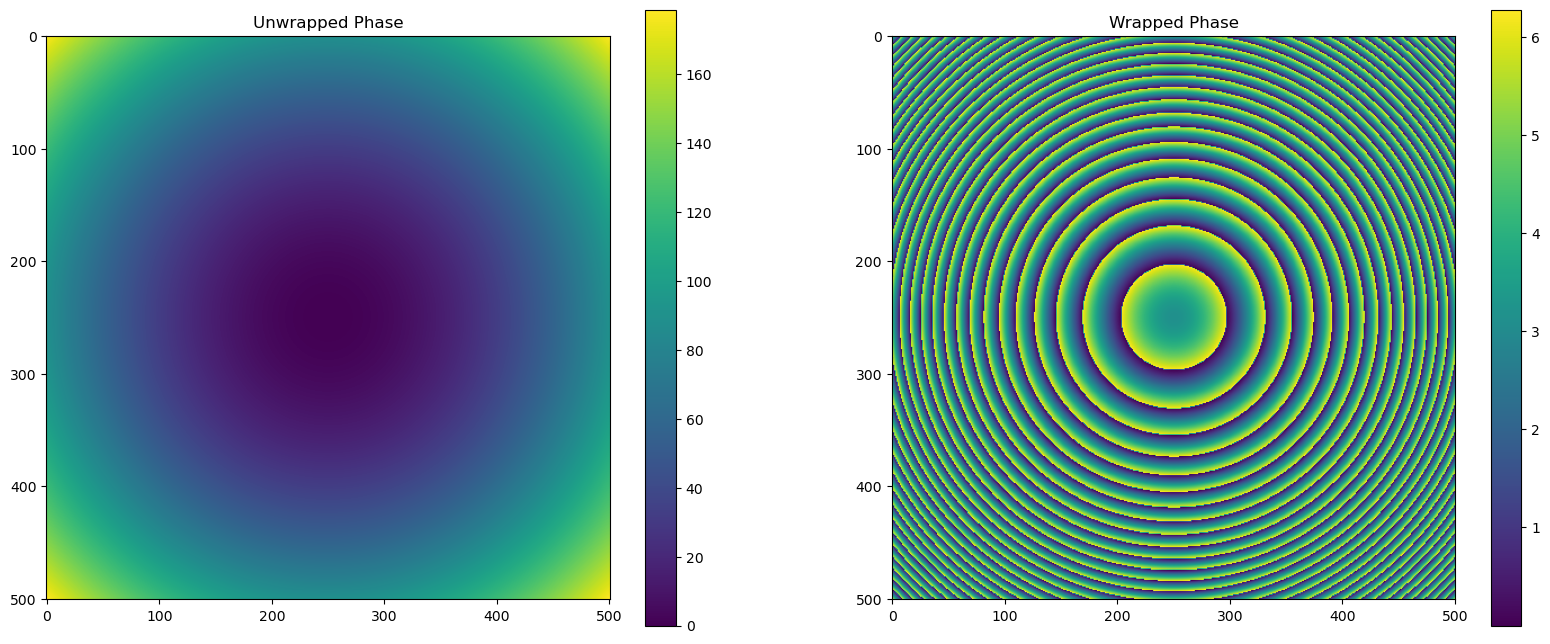

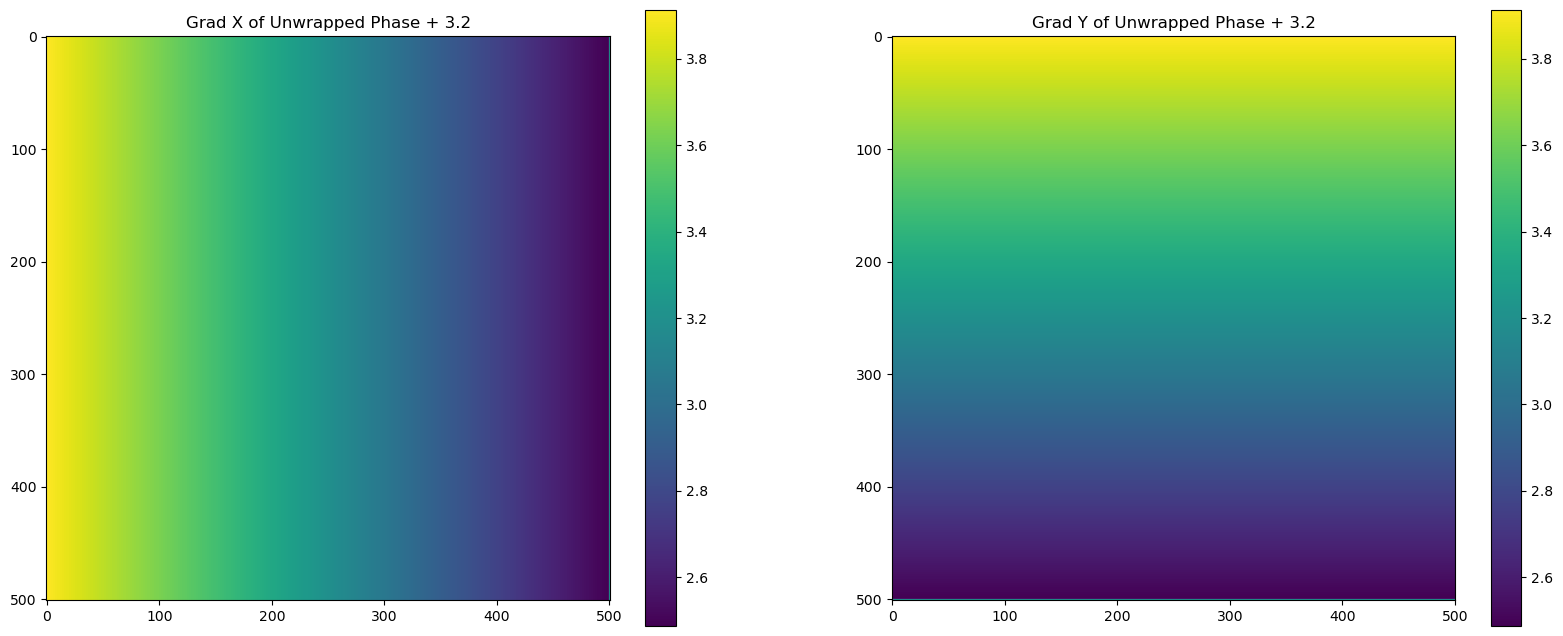

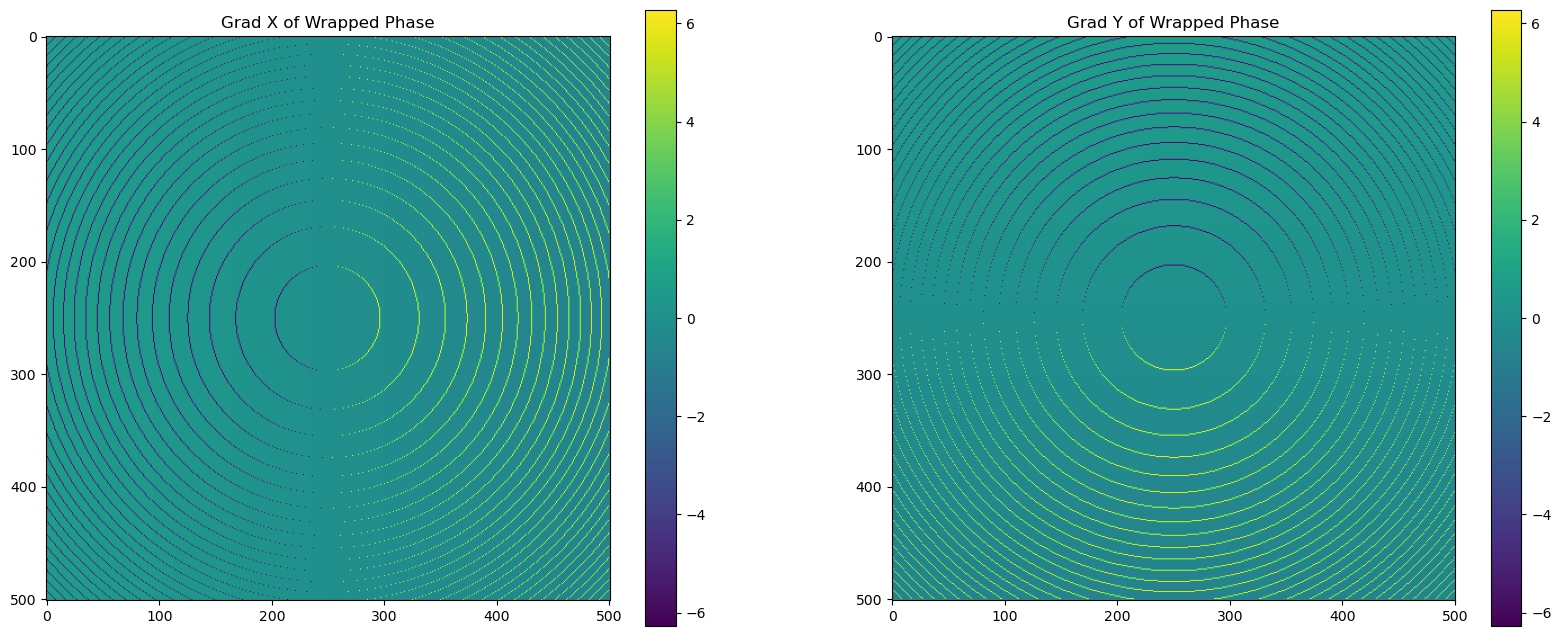

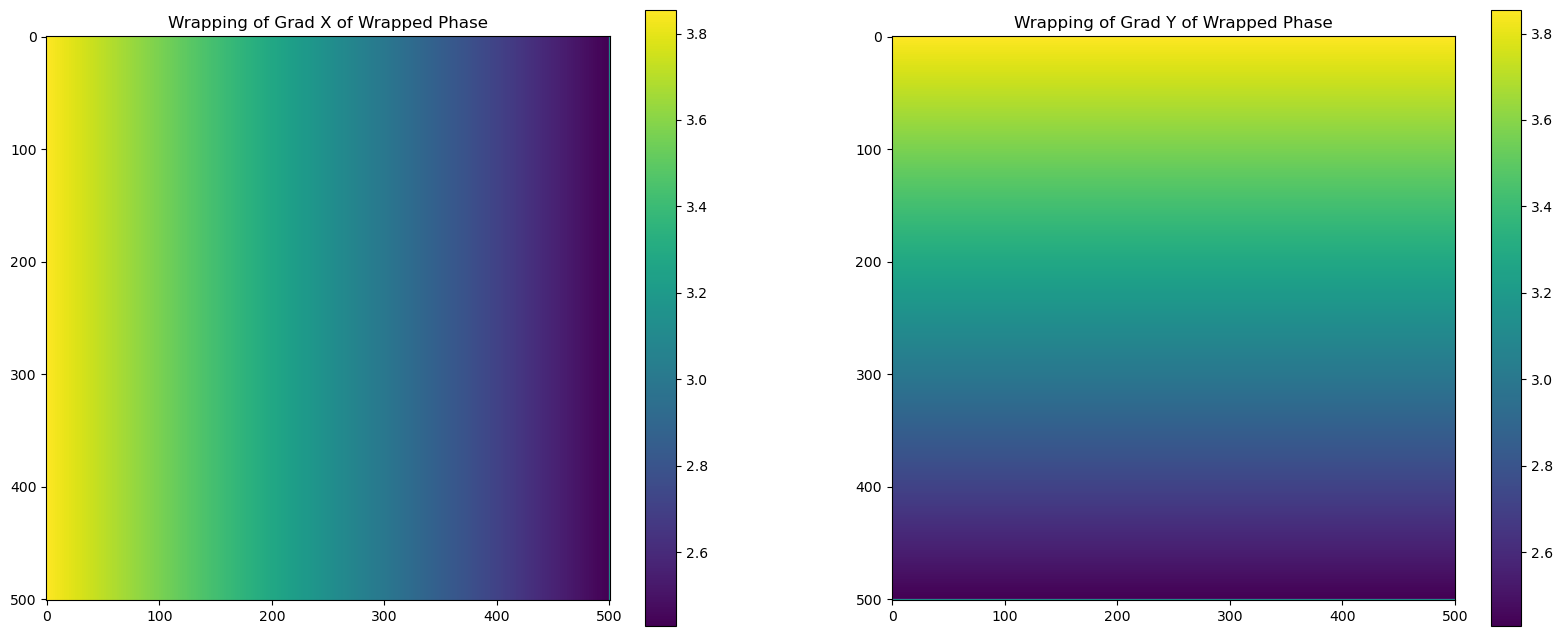

In [4]:
X, Y = np.meshgrid(np.linspace(-250, 250, 501), np.linspace(-250, 250, 501))
Z = torch.tensor((X**2 + Y**2)/700)
Z_wrap = wrap(Z)

fig, axs = plt.subplots(1, 2, figsize=(20, 8))
cm0 = axs[0].imshow(Z)
cm1 = axs[1].imshow(Z_wrap)

axs[0].set_title("Unwrapped Phase")
axs[1].set_title("Wrapped Phase")

fig.colorbar(cm0, ax=axs[0])
fig.colorbar(cm1, ax=axs[1])

plt.show()

fig, axs = plt.subplots(1, 2, figsize=(20, 8))
cm0 = axs[0].imshow(grad_optr(Z)[0] + 3.2)
cm1 = axs[1].imshow(grad_optr(Z)[1] + 3.2)

fig.colorbar(cm0, ax=axs[0])
fig.colorbar(cm1, ax=axs[1])

axs[0].set_title("Grad X of Unwrapped Phase + 3.2")
axs[1].set_title("Grad Y of Unwrapped Phase + 3.2")

plt.show()

fig, axs = plt.subplots(1, 2, figsize=(20, 8))
cm0 = axs[0].imshow(grad_optr(Z_wrap)[0])
cm1 = axs[1].imshow(grad_optr(Z_wrap)[1])

fig.colorbar(cm0, ax=axs[0])
fig.colorbar(cm1, ax=axs[1])

axs[0].set_title("Grad X of Wrapped Phase")
axs[1].set_title("Grad Y of Wrapped Phase")

plt.show()

fig, axs = plt.subplots(1, 2, figsize=(20, 8))
cm0 = axs[0].imshow(wrap(grad_optr(Z_wrap)[0]))
cm1 = axs[1].imshow(wrap(grad_optr(Z_wrap)[1]))

fig.colorbar(cm0, ax=axs[0])
fig.colorbar(cm1, ax=axs[1])

axs[0].set_title("Wrapping of Grad X of Wrapped Phase")
axs[1].set_title("Wrapping of Grad Y of Wrapped Phase")

plt.show()

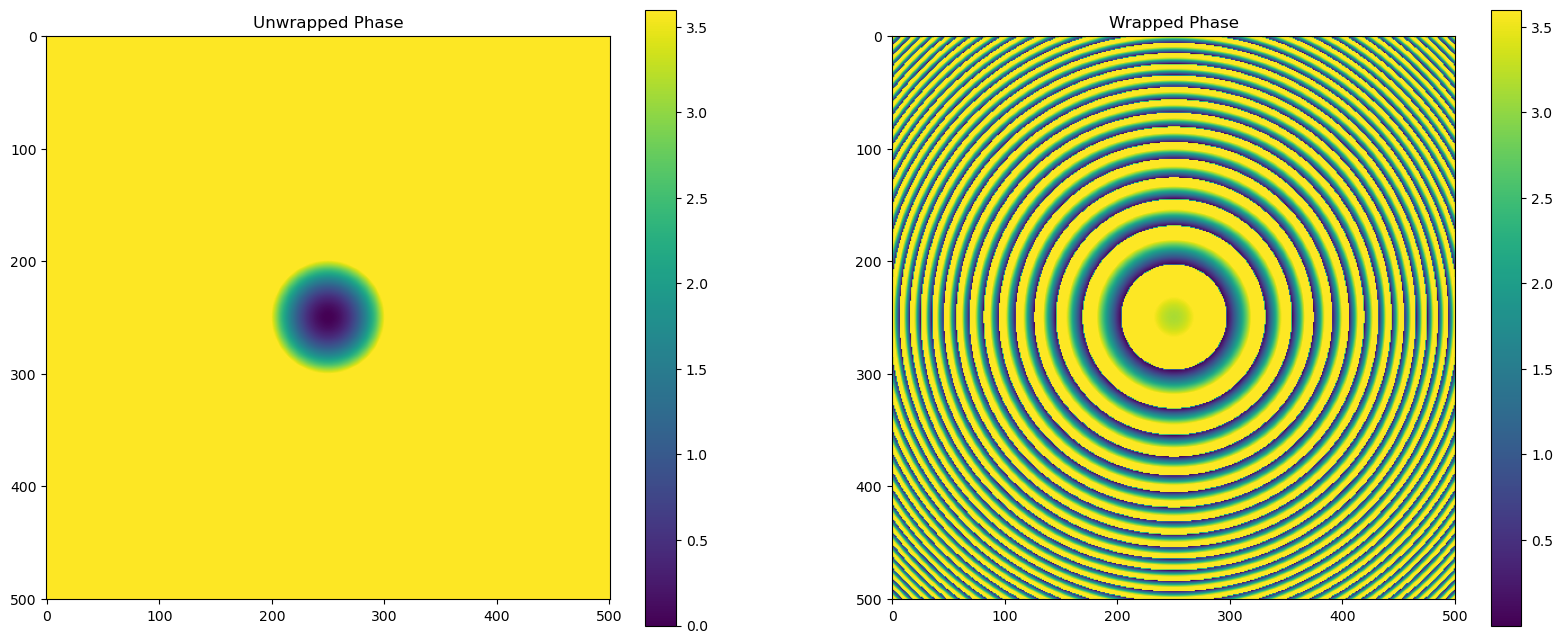

In [5]:
fig, axs = plt.subplots(1, 2, figsize=(20, 8))
cm0 = axs[0].imshow(torch.clamp(Z, 0, 3.6))
cm1 = axs[1].imshow(torch.clamp(Z_wrap, 0, 3.6))


axs[0].set_title("Unwrapped Phase")
axs[1].set_title("Wrapped Phase")

fig.colorbar(cm0, ax=axs[0])
fig.colorbar(cm1, ax=axs[1])

plt.show()

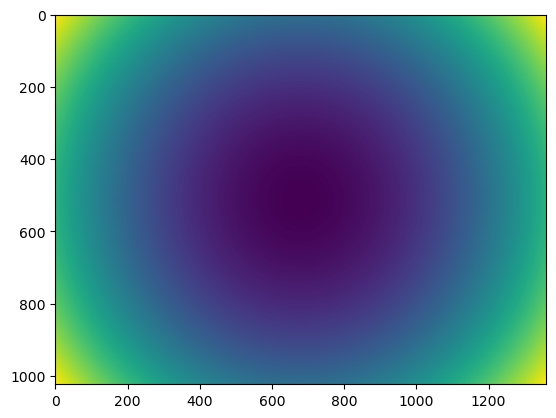

In [6]:
X, Y = np.meshgrid(np.linspace(-512, 511, 1024), np.linspace(-680, 679, 1360))
Z = torch.tensor((X.T**2 + Y.T**2)/15000)

plt.imshow(Z.repeat(10, 1, 1)[1, :, :])

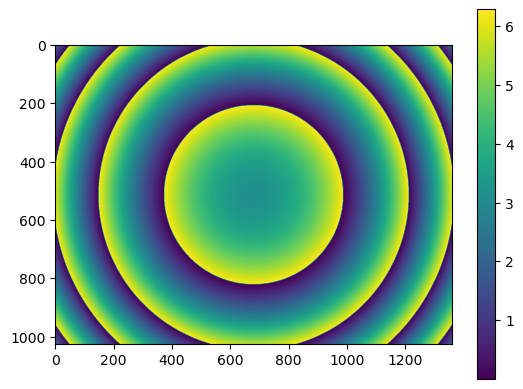

In [7]:
# phase_img = np.load('phase_0.npy')
# plt.imshow(phase_img)
# plt.colorbar()
# phase_img.dtype

X, Y = np.meshgrid(np.linspace(-512, 511, 1024), np.linspace(-680, 679, 1360))
Z = torch.tensor((X.T**2 + Y.T**2)/30000)
phase_img = wrap(Z)
plt.imshow(phase_img)
plt.colorbar()

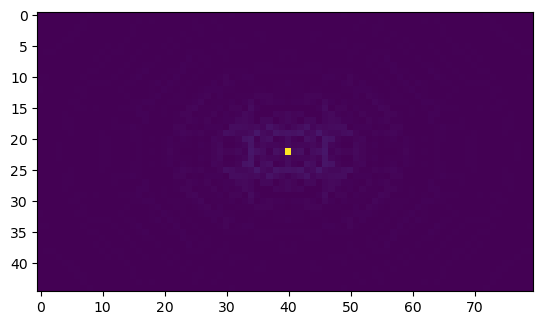

In [8]:
plt.imshow(np.abs(np.fft.fftshift(np.fft.fft2(phase_img)))[490:535, 640:720])

In [9]:
# fft =  np.fft.fftshift(np.fft.fft2(phase_img))
# for i in range(2000):
#     fft = np.where(np.abs(fft) < np.abs(fft).max(), fft, 0.)
# plt.imshow(np.abs(fft[490:535, 640:720]))
# plt.colorbar()
# plt.show()


# plt.imshow(np.abs(np.fft.ifft2(np.fft.ifftshift(fft))))
# plt.colorbar()
# plt.show()


# plt.imshow(phase_img - np.abs(np.fft.ifft2(np.fft.ifftshift(fft))))
# plt.colorbar()
# plt.show()

In [18]:
device = torch.device('cuda:0')

model = UNet(num_input_channels=128, num_layers_to_concat = 4, upsample_mode='bilinear', 
             pad='zero', norm_layer=nn.BatchNorm2d, need_sigmoid=True, need_bias=True).to(device)

optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9, 0.999))


In [19]:
epochs = 400
e_old = 0.
loss_arr = []

dimx, dimy = phase_img.shape
data = torch.rand([1, 128, dimx, dimy]).to(device)
data = Z.clone().detach().repeat(128, 1, 1).unsqueeze(0).float().to(device)
target = phase_img.clone().detach().to(device)

for e in range(epochs):

    optimizer.zero_grad()
    
    pred = model(data)
    loss, e_old = loss_fn(pred, target, e, e_old, emin=0.01, emax=8, update_iter=500)
    e_old = e_old.detach()
    loss.backward()
    optimizer.step()
    loss_arr.append(loss.item())

    print(e, loss_arr[-1])

0 1392640.0
1 1392640.0272791483
2 1392001.233520105
3 1392535.7846077797
4 1391546.1635298464
5 1389124.9282708643
6 1386307.0150491032
7 1388452.9948516348
8 1388216.4119787423
9 1383592.6755725425
10 1385142.4662415618
11 1379860.4182423474
12 1377607.8664838728
13 1375145.6259899887
14 1371620.6059621754
15 1368037.0993097636
16 1366728.6429084109
17 1365364.3723815987
18 1366577.8650298398
19 1364763.8732220335
20 1361480.7839550227
21 1354658.57638348
22 1352386.3245110845
23 1349492.51398755
24 1346567.9539335864
25 1344681.7474588538
26 1345807.7466811403
27 1340264.183596042
28 1334956.710216688
29 1332950.7961571442
30 1330657.3011168796
31 1328283.0809670761
32 1324200.1876548193
33 1321593.9793272302
34 1317707.0071303118
35 1316220.2756139622
36 1311420.5930710034
37 1308504.1727471212
38 1306616.7297781487
39 1304869.2345270575
40 1299267.3453498357
41 1293968.7219487873
42 1292027.6903383941
43 1287446.475252565
44 1285278.8477428453
45 1282617.2452274612
46 1281070.8042

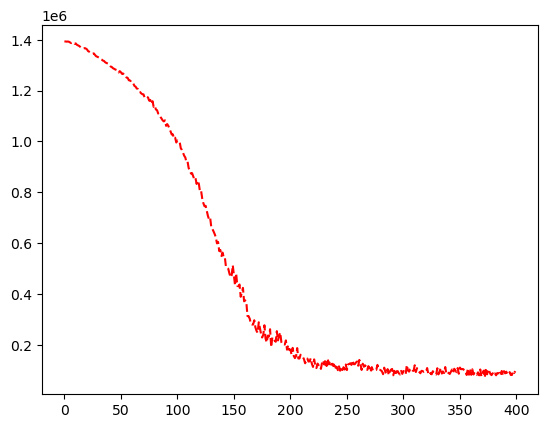

In [20]:
plt.plot((loss_arr), 'r--')

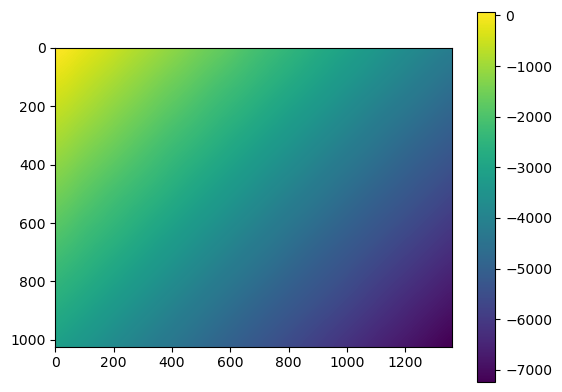

In [21]:
estimate = model(data).cpu().detach().squeeze()
plt.imshow(estimate)
plt.colorbar()

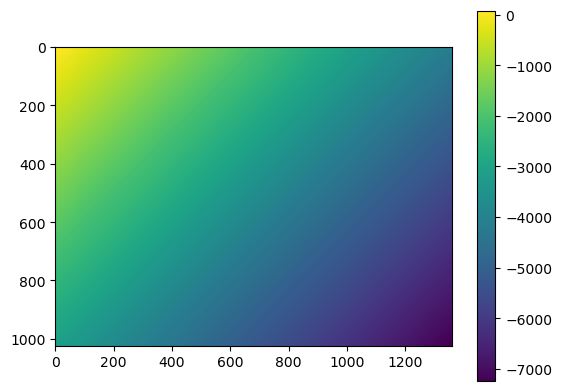

In [22]:
estimate = model(data).cpu().detach().squeeze()
estimate += wrap(target.cpu() - estimate)
plt.imshow(estimate)
plt.colorbar()

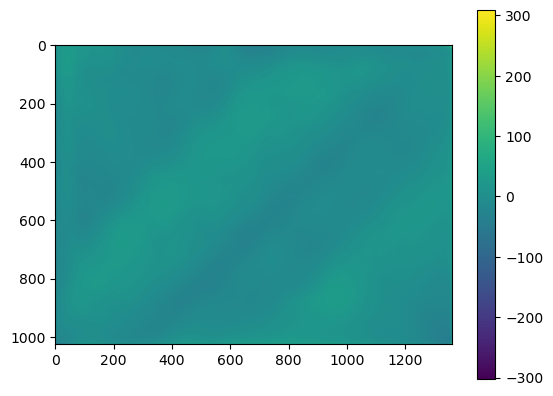

: 

In [23]:
X, Y = np.meshgrid(np.linspace(1, dimx, dimx), np.linspace(1, dimy, dimy))

A = np.array([X.T.ravel(), Y.T.ravel(), X.T.ravel()*Y.T.ravel(), X.T.ravel()*X.T.ravel(), Y.T.ravel()*Y.T.ravel(), np.ones_like(X.T.ravel()),
              (X.T.ravel())**3, (Y.T.ravel())**3, X.T.ravel()*(Y.T.ravel())**2, Y.T.ravel()*(X.T.ravel())**2], dtype=np.float64).T

# print(unwrapped_kamui.ravel().shape)
a = np.matmul(np.matmul(np.linalg.inv(np.matmul(A.T, A)), A.T), estimate.ravel())

lin_phase = (A@a.numpy()).reshape(dimx, dimy)

plt.imshow(estimate-lin_phase)
plt.colorbar()
plt.show()

In [82]:
gc.collect()
torch.cuda.empty_cache()